# Training and evaluation

## 1. Setup and load

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load the processed dataset
# We use the cleaned dataset from the previous step
input_path = '../data/processed/complaints_processed.csv'

print("⏳ Loading processed dataset...")
df = pd.read_csv(input_path) 

# Remove any NaN values that may have been introduced during cleaning
df = df.dropna(subset=['processed_text', 'target'])

print(f"✅ Data ready for modeling. Shape: {df.shape}")
display(df.head())

⏳ Loading processed dataset...
✅ Data Ready for Modeling. Shape: (333072, 3)


,text,target,processed_text
0,The Summer of XX/XX/2018 I was denied a mortga...,Credit Reporting,summer deny mortgage loan charge credit card m...
1,There are many mistakes appear in my report wi...,Credit Reporting,mistake appear report understanding
2,There are many mistakes appear in my report wi...,Credit Reporting,mistake appear report understanding
3,There are many mistakes appear in my report wi...,Credit Reporting,mistake appear report understanding
4,There are many mistakes appear in my report wi...,Credit Reporting,mistake appear report understanding


## 2. Split (Stratified)

In [ ]:
# Define X (Features) and y (Target)
X = df['processed_text']
y = df['target']

# Train-Test Split
# We use a standard 80-20 split.
# stratify=y ensures the class distribution is preserved in both sets.
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples:  {len(X_test)}")

Splitting data...
Training samples: 266457
Testing samples:  66615


## 3. TF-IDF vectorization

In [3]:
# Configure TF-IDF
# - max_features=5000: Keep only the top 5k terms to save memory/speed.
# - ngram_range=(1, 2): Capture "credit" (1) and "credit card" (2).
tfidf = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2),
    min_df=10,       # Ignore terms appearing in fewer than 10 docs
    max_df=0.95      # Ignore terms appearing in >95% of docs (too common)
)

print("⏳ Vectorizing text (TF-IDF)...")
# Fit only on Train to prevent Data Leakage
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✅ Vectorization complete. Train shape: {X_train_tfidf.shape}, Test shape: {X_test_tfidf.shape}")

⏳ Vectorizing text (TF-IDF)...
✅ Vectorization complete. Train shape: (266457, 5000), Test shape: (66615, 5000)


## 4. Random forest training

In [ ]:
# Initialize Random Forest
# - n_estimators=100: Standard number of trees.
# - class_weight='balanced': CRITICAL. Helps with imbalanced classes (e.g., fewer Retail Banking).
# - n_jobs=-1: Use all CPU cores for faster training.
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    verbose=1 # This will print progress logs
)

print("🚀 Training random forest model... (This might take 5-10 minutes)")
rf_model.fit(X_train_tfidf, y_train)
print("✅ Training complete!")

🚀 Training Random Forest Model... (This might take 5-10 minutes)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.3min


✅ Training complete!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.5min finished


## 5. Evaluation

🔮 Predicting on Test Set...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished



📊 CLASSIFICATION REPORT
                  precision    recall  f1-score   support

     Credit Card       0.85      0.80      0.82      8334
Credit Reporting       0.89      0.93      0.91     24790
 Debt Collection       0.89      0.87      0.88     17340
       Mortgages       0.92      0.93      0.93     10598
  Retail Banking       0.87      0.83      0.85      5553

        accuracy                           0.89     66615
       macro avg       0.88      0.87      0.88     66615
    weighted avg       0.89      0.89      0.89     66615



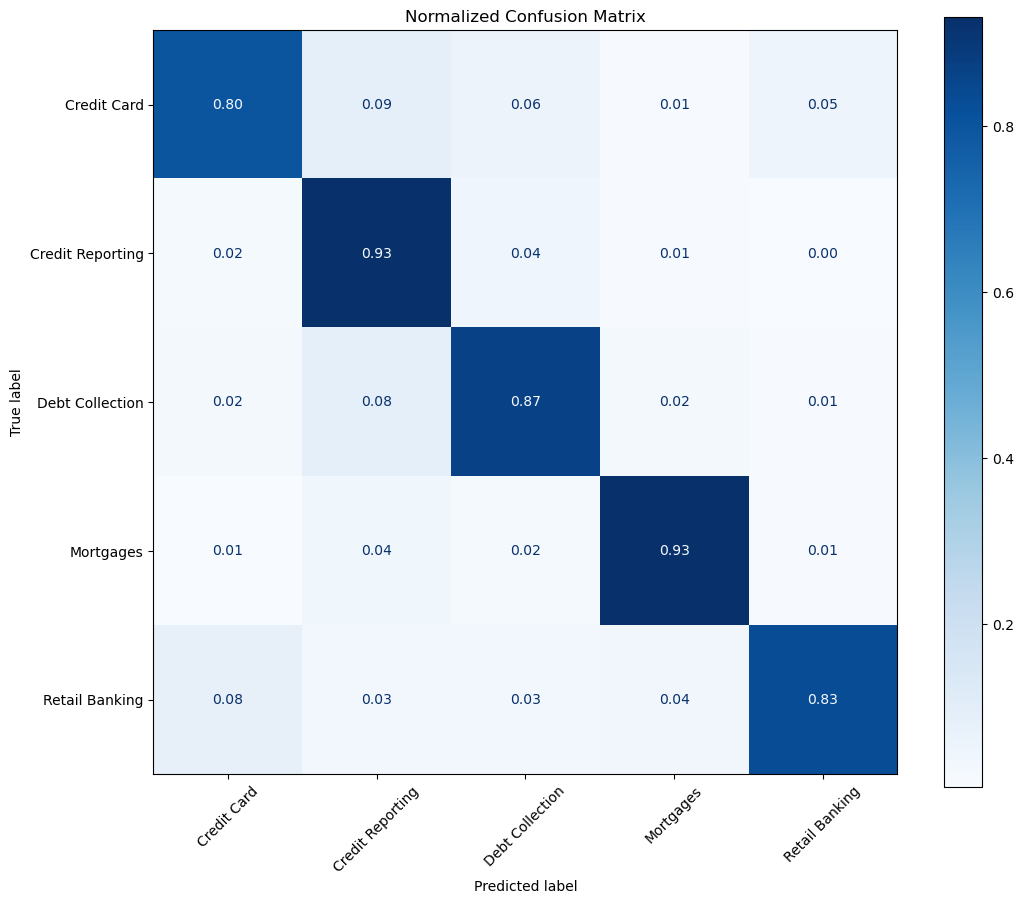

In [ ]:
# Predict on test set
print("🔮 Predicting on test set...")
y_pred = rf_model.predict(X_test_tfidf)

# Classification report
print("\n" + "="*60)
print("📊 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred))

# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=ax, 
    cmap='Blues',
    xticks_rotation=45,
    normalize='true', # Show percentages, easier to compare
    values_format='.2f'
)
plt.title('Normalized confusion matrix')
plt.show()

### IMPORTANT❗

In [ ]:
# ==============================================================================
# 🚀 DEPLOYMENT TIP: REDUCING MODEL SIZE FOR GITHUB/PRODUCTION
# ==============================================================================
# The current Random Forest model is optimized for accuracy (F1 ~0.89), 
# but the .pkl file can be very large (>500MB) due to unlimited tree depth.
# GitHub has a strict file limit of 100MB.

# If you need to push the model to GitHub or deploy to a resource-constrained 
# environment (e.g., Streamlit Cloud, AWS Free Tier), use the following configuration:

# 1. LIMIT TREE DEPTH (Sacrifices ~1-2% accuracy for 80% size reduction)
# rf_optimized = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=15,        # <--- Crucial: Limits tree growth
#     min_samples_leaf=5,  # <--- Prunes noisy branches
#     class_weight='balanced',
#     n_jobs=-1,
#     random_state=42
# )

# 2. ENABLE COMPRESSION WHEN SAVING
# import joblib
# joblib.dump(rf_optimized, '../models/rf_compressed.pkl', compress=3) # Level 3 compression
# joblib.dump(tfidf, '../models/tfidf_compressed.pkl', compress=3)

# Result: File size drops from ~900MB to ~80MB.
# ==============================================================================

## 6. Visualizing feature importance

C:\Users\javie\AppData\Local\Temp\ipykernel_19524\2715978664.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


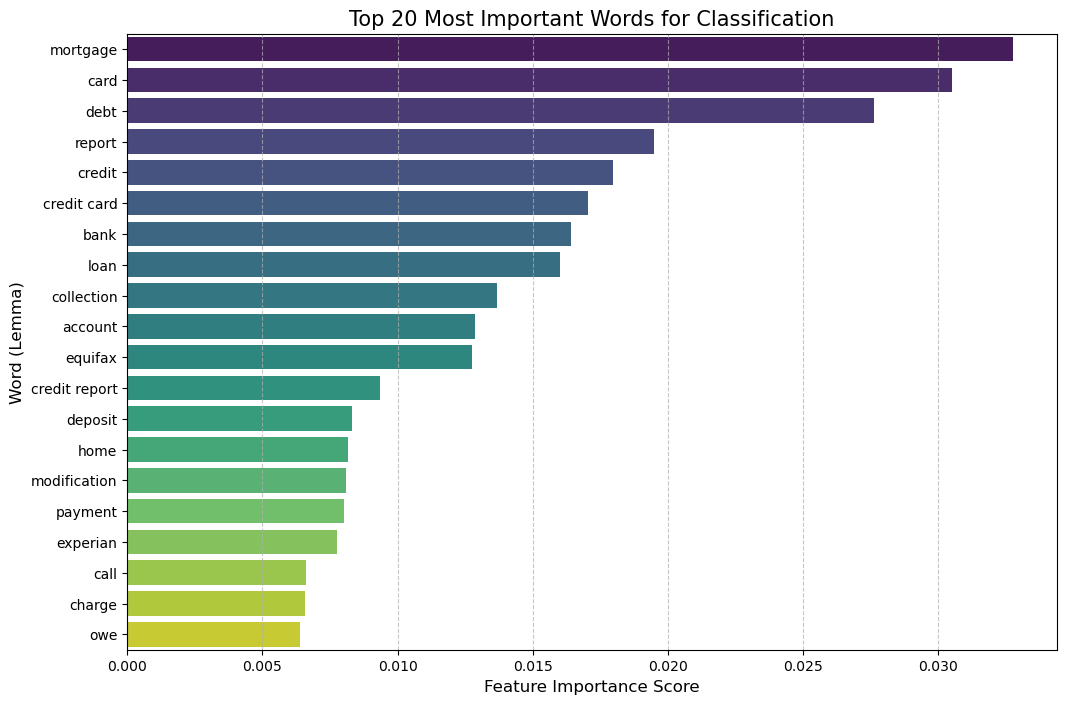

💾 Saving model artifacts...
✅ Model and Vectorizer saved in 'models/' folder.


In [ ]:
# ---------------------------------------------------------
# Feature importance analysis
# ---------------------------------------------------------

# Extract feature names (words) from TF-IDF
feature_names = tfidf.get_feature_names_out()

# Extract importance scores from random forest
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
top_features = feature_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 most important words for classification', fontsize=15)
plt.xlabel('Feature importance score', fontsize=12)
plt.ylabel('Word (Lemma)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ---------------------------------------------------------
# Save the model for production
# ---------------------------------------------------------
import joblib

# We need to save BOTH the model AND the vectorizer
# Without the vectorizer, the model can't understand new text.
print("💾 Saving model artifacts...")
joblib.dump(rf_model, '../models/random_forest_classifier.pkl')
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')
print("✅ Model and vectorizer saved in 'models/' folder.")